# Implementing the `write_report()` tool and testing it out

## Brainstorming



We want the model to be able to produce a report of the analysis performed. 

What it should do:

1. *Get the full chat history in order to see al relevant analysis performed*
    
    **challenges:** 

    - If chat gets summarized, previous analysis are blurred out. We need detailed history, but at the same time we cannot input more than a certain number of tokens to the model that produces the analysis. 
    
    **solutions:**

    - we need to keep the full chat state somewhere when we summarize. Maybe store it in state. Could be a long `analysis` str, or could be a virtual file in the virtual file system. Then the `write_report()` tool could split the full history in sections in order not to exceed context length.     

2. *Collect all sources used - meaning, the list of all datasets analized*
    
    **challenges:**

    - We have to keep track of all used datasets.
    
    **solutions:**
    
    - Just add a state var `sources`; it gets filled every time we **select** a dataset with the `select_dataset` tool. The model that writes the report can then cite the source throughout the report, understanding when it was used from chat history.

3. *Produce an extensive report (.md format probably)*

----

> **? Should the report include python code ?**
>
> It could be useful to include in the report - or somewhere else - all python code written during the analysis. 
> If could be a section/appendyx in the report, or a separate file that the user can ask to be given. 
> or simply another state str that gets filled up anytime the code exec runs - then we manually combine it into an appendyx in the report. i Just don't want it to be like 3000 lines at the end of the report. maybe they should be separate files. 

> *DB Related:* This extra stuff needs to remain visible to the user when he goes back to previous chats - add those in the db 


## Implementation, pt.1

We will now: 

1. create a new state with the new state vars we need
2. give the model a simpler repl tool that can still generate python code and get stdout and stderr - or make it fake
3. give the model a fake select ds tool that adds the sources to state var
4. create the real write_report() tool (and a nice prompt) for the model to use all the rest. 
5. make it write to file so we can read it.   

### 1. State Vars

In [1]:
from langgraph.prebuilt.chat_agent_executor import AgentState
from typing import Annotated, Optional

def merge_dicts(
    left: dict[str, str] | None = None,
    right: dict[str, str] | None = None
) -> dict[str, str]:
    """Merge two dictionaries. Left takes precedence over right. Used for reports."""
    if left is None:
        left = {}
    if right is None:
        right = {}
    return {**left, **right}

def merge_dicts_nested(
    left: dict[str, dict[str, str]] | None = None, 
    right: dict[str, dict[str, str]] | None = None
) -> dict[str, dict[str, str]]:
    """Merge two nested dictionaries. Left takes precedence over right. Used for sources."""
    if left is None:
        left = {}
    if right is None:
        right = {}
    return {**left, **right}

def list_add(
    left: list[dict[str, str]] | None = None,
    right: list[dict[str, str]] | None = None
) -> list[dict[str, str]]:
    """Add a new item to a list. Used for code. No deduplication - running the same code twice is meaningful."""
    if left is None:
        left = []
    if right is None:
        right = []
    
    return left + right

class MyState(AgentState):
    # here we would have also summary and token count
    sources : Annotated[dict[str, dict[str, str]], merge_dicts_nested] # key is the dataset id, value is a dict with desc, url
    reports: Annotated[dict[str, str], merge_dicts]  # key is the title, value is the content 
    last_report_title : Optional[str]
    edit_instructions : str # Not Optional - use "" as "no instructions"
    code_logs: Annotated[list[dict[str, str]], list_add]  # list of dicts (we need chronologcal order!), each dicts is input and output of a code block (out can be stdout or stderr)

Will these reducers work well with left + right if they are dicts?

### 2. & 3. Fake tools

In [2]:
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import ToolMessage
from langgraph.types import Command


@tool
def code_exec(
    code: Annotated[str, "The python code to execute to generate your chart."],
    tool_call_id: Annotated[str, InjectedToolCallId]
)->Command: 
    """Use this to execute python code."""

    result = """# code executed succesfully"""  # this would be stdout
    code_dict = {"input": code, "output": result}

    return Command(
        update = {
            "messages" : [ToolMessage(content = result, tool_call_id = tool_call_id)],
            "code_logs": [code_dict], # wrap in list for reducer
        }
    )

@tool 
def select_dataset(
    dataset_id: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
)->Command:
    """
    Select a dataset from the list of available datasets. Adds it to the list of sources automatically.
    """

    dataset_dict = {dataset_id: {"desc": "dataset test description", "url": "dataset test url"}}
    return Command(
        update = {
            "messages" : [ToolMessage(content = f"Selected and loaded dataset {dataset_id}", tool_call_id = tool_call_id)],
            "sources" : dataset_dict
        }
    )

### 4. & 5. Write report tool

TODO: We can actually add interruption before the tool is called, so that the user can reject the report writing if not needed. 

In [3]:
def write_report(
    report_title: Annotated[str, "The title of the report"],
    report_content: Annotated[str, "The content of the report"],
    tool_call_id: Annotated[str, InjectedToolCallId]
)->Command:
    """
    Write a report of the analysis performed.
    """

    report_dict = {report_title: report_content}

    # also write to file in dev
    with open("report.md", "a") as f:
        f.write(f"# {report_title}\n{report_content}\n\n")

    return Command(
        update = {
            "messages" : [ToolMessage(content = "Report written", tool_call_id = tool_call_id)],
            "reports" : report_dict,
            "last_report_title" : report_title
        }
    )

# probably should make a modify_report() tool that can be used to add to modify an existing report


How should i make it add sources? first make the report than another pass for sources? A `read_sources` tool?

Maybe for the moment we keep it simple and just invoke the agent on messages and sources. He will add sources at the end. 

### 6. Create a well rounded prompt

In [4]:
report_prompt = """
You are an AI assistant that works together with a data analyst colleague.

After the data analyst performs an analysis, you will be asked to write a report of the analysis performed.

In order to do so, you MUST use your `write_report()` tool. It takes 2 arguments:

1. `report_title`: a string with the title of the report
2. `report_content`: a string with the content of the report

The title and the content MUST be formatted in markdown.

For the content, follow these instructions:

1. Do not include the title in the content. It will be added automatically.
2. Structure the report in subsections, each with a title and a content.
3. For each subsection, include the analysis performed in a comprehensive way, covering all the main points, and going into detail when needed.
4. At the end of the report, add a section "Sources" where you list all the sources used in the analysis.
5. NEVER include python code in the report.

You may be asked either to write a new report or to revise an existing one. 
If you revise an existing report, follow the edit instructions that you will be given.

"""

## Implementation, pt.2 - Graph

The second part of the implementation reguards the graph structure. We want to have:

1. A node that invokes the report writer on messages and sources. 
2. A *human-edit step*, where the user can edit the report if he wants.

> Note: A *human-approval step*, where the user can confirm or deny the report writing, will be in the tool directly

### 1. Create the agents (report writer + fake analyst)

First let's create our two agents, the fake analyst and the "almost-real" report writer. 

In [5]:
analyst_prompt = """
You are an AI assistant that works together with a report writing colleague.

You perform analysis on the datasets at your disposal, and when the analysis is finished you route to the report writer in order to write the report.
In order to route to the report writer, you MUST end your answer with "WRITE REPORT".

This specific run is a test; you MUST follow these steps:

1. Select the datasets "dataset1" and "dataset2" with the `select_dataset` tool

2. Use your `code_exec` tool to execute this code snippet:
```python
# analysis code
import pandas as pd

df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")

# plot results
plt.figure()
plt.plot(df1["x"], df1["y"])
plt.plot(df2["x"], df2["y"])
plt.show()
```

3. Route to the report writer agent by ending your answer with "WRITE REPORT".
"""

In [6]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv

env = load_dotenv()

analyst_llm = ChatOpenAI(model="gpt-4.1", temperature=0)
report_llm = ChatAnthropic(model="claude-sonnet-4-5")

# report writer agent
report_agent = create_react_agent(
    model=report_llm,
    prompt=report_prompt,
    tools=[write_report],
    state_schema=MyState
)

# analyst agent
analyst_agent = create_react_agent(
    model=analyst_llm,
    prompt=analyst_prompt,
    tools=[code_exec, select_dataset], 
    state_schema=MyState
)


In [7]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.types import interrupt


def make_graph(checkpointer):
    """
    Defines nodes and edges, builds and compiles the graph
    """

    # is there a better way to route to the report writer? The WIRTE REPORT str will surface on messages like this
    # maybe give a tool `assing_to_report_writer`? 
    async def get_next_node(last_msg: BaseMessage):
        if last_msg.content.endswith("WRITE REPORT"):
            return "report_writer"
        else:
            return "__end__"

    async def analyst_node(state: MyState,
    ) -> Command[Literal["report_writer", "__end__"]]:  
        """
        Invokes the analyst agent
        """
        result = await analyst_agent.ainvoke({"messages": state["messages"]})
        last_msg = result["messages"][-1]

        goto = await get_next_node(last_msg, "report_writer")

        return Command(
            update = {
                "messages" : [last_msg],
            },
            goto = goto
        )

    async def write_report_node(state: MyState,
    ) -> Command[Literal["human_approval"]]:
        """
        Invokes the report writer agent
        """

        if state["edit_instructions"] != "":
            sys_msg = f"Revise the report based on the following instructions: {state['edit_instructions']}"
            messages = state["messages"] + [SystemMessage(content=sys_msg)]
        else:
            sys_msg = "Write a new report based on the analysis performed and the sources used."
            messages = state["messages"] + [SystemMessage(content=sys_msg)]

        result = await report_agent.ainvoke({"messages": messages, "sources": state["sources"]})
        last_msg = result["messages"][-1]

        return Command(
            update = {
                "messages" : [last_msg],
                "edit_instructions" : ""  # clear it if writer revised it
            },
            goto = "human_approval"  # always route to human edit
        )

    async def human_approval_node(state: MyState,
    ) -> Command[Literal["report_writer", "__end__"]]:
        """
        Human approval step
        """
        decision = interrupt({
            "question": "The report has been generated. If you approve the report, input 'yes' - once approved, you can manually edit it. If instead you want the model to edit it, input your desired changes.",
            "report": state["reports"][state["last_report_title"]]
        })

        if decision == "yes":
            return Command(goto="__end__")
        else:
            return Command(goto="report_writer", update={"edit_instructions": decision})


    builder = StateGraph(MyState)
    builder.add_node("analyst", analyst_node)
    builder.add_node("report_writer", write_report_node)
    builder.add_node("human_approval", human_approval_node)
    builder.add_edge(START, "analyst")
    return builder.compile(checkpointer=checkpointer)

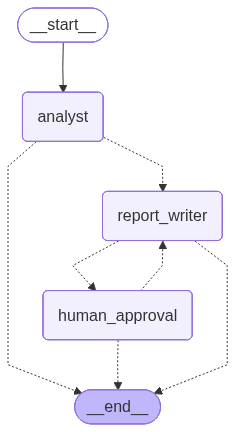

In [8]:
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

checkpointer = InMemorySaver()

graph = make_graph(checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))